## Load the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import pointbiserialr
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import SGDClassifier
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [2]:
# Import data from working directory
loans = pd.read_csv('loan_data.csv')
loans.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## Exploratory analysis

### Descriptive statistics

In [3]:
loans.shape

(32581, 12)

Data is composed of 32581 observations (loans) and 12 variables.

In [4]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


**Observations:**
- The person_emp_length and loan_int_rate columns have missing values that should be addressed.  
- There are also some categorical columns (person_home_ownership, loan_intent, loan_grade, cb_person_default_on_file) that need to be encoded before modeling. 

In [5]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
loans.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.00,32581.00,31686.00,32581.00,29465.00,32581.00,32581.00,32581.00
mean,27.73,66074.85,4.79,9589.37,11.01,0.22,0.17,5.80
std,6.35,61983.12,4.14,6322.09,3.24,0.41,0.11,4.06
min,20.00,4000.00,0.00,500.00,5.42,0.00,0.00,2.00
25%,23.00,38500.00,2.00,5000.00,7.90,0.00,0.09,3.00
50%,26.00,55000.00,4.00,8000.00,10.99,0.00,0.15,4.00
75%,30.00,79200.00,7.00,12200.00,13.47,0.00,0.23,8.00
max,144.00,6000000.00,123.00,35000.00,23.22,1.00,0.83,30.00


**Observations:**
- person_age and person_emp_length have outlier values (maximum values unrealistic).
- Scales differ due to different units (e.g. age vs dollar amount). Rescaling should be considered. 

In [6]:
# Analyze dependent variable: loan status
print(loans['loan_status'].value_counts())
print()
default_loans = loans['loan_status'].value_counts()[1]
print(f'Out of {len(loans)} loans there are {default_loans} loans that defaulted')

0    25473
1     7108
Name: loan_status, dtype: int64

Out of 32581 loans there are 7108 loans that defaulted


In [7]:
# Get default rate
default_rate = loans['loan_status'].sum()/len(loans['loan_status']) * 100
print(f'The default rate is {default_rate:.2f}%.')

The default rate is 21.82%.


**Observations:**
- 21.82 % of observations are of class 1 (default) and 78.18 % of class 0 (no default). 
- Class imbalance may affect model performance and should be addressed. 

### Data visualizations

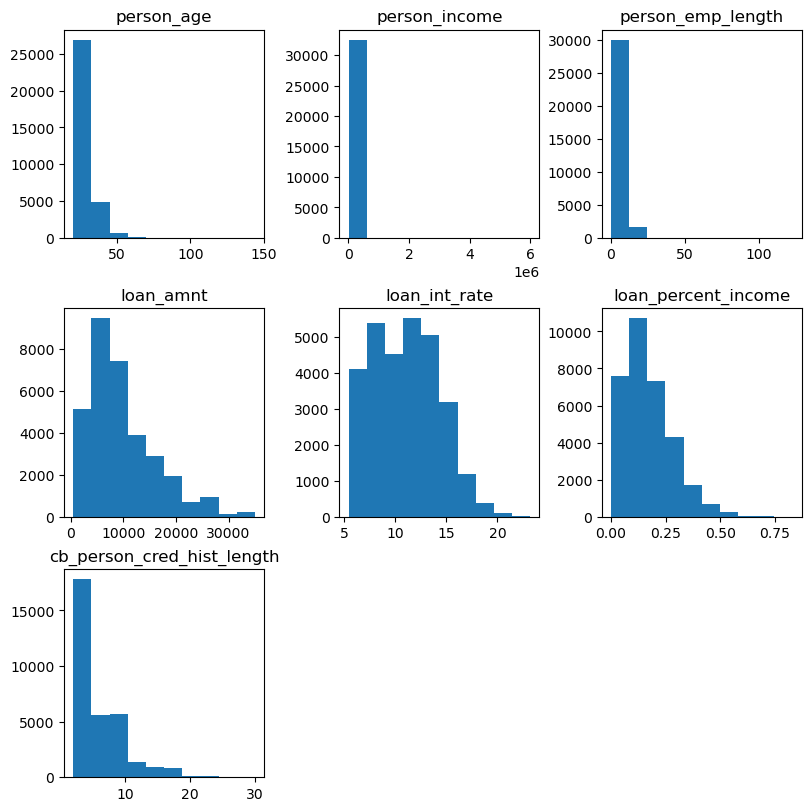

In [8]:
# Histograms of continuous variables 
continuous_variables = loans.select_dtypes('number').drop(['loan_status'],axis=1)
plt.figure(figsize=(8,8), layout='constrained')
for i in enumerate(continuous_variables):
    plt.subplot(3,3,i[0]+1)
    plt.hist(loans[i[1]])
    plt.title(i[1])

plt.show()

**Observations:**
- Outliers of person_age and person_emp_length are confirmed by histograms. 
- Seems that person_income also contains outliers. 
- Other variables are all right-skewed. Removal of skewness may help to improve model performance. 

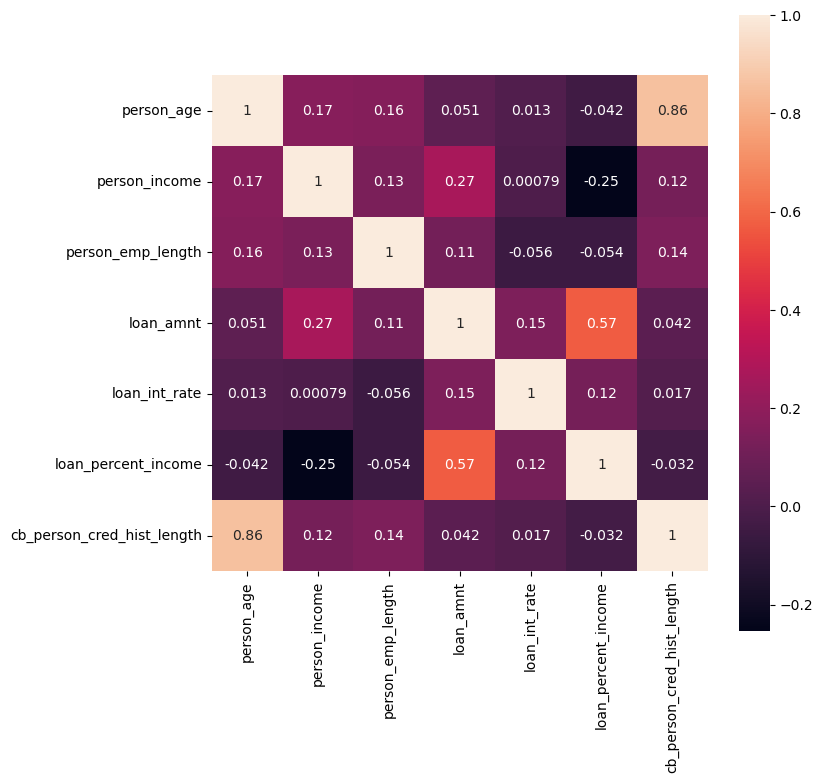

In [9]:
# Correlation among continuous features
plt.figure(figsize=(8,8))
corr_matrix = continuous_variables.corr(numeric_only=True)
sns.heatmap(corr_matrix,annot=True, square=True)
plt.show()

In [10]:
# Correlation between continuous features and output variable 
pb_corr = continuous_variables.corrwith(loans['loan_status'],method=pointbiserialr)
pb_corr.index = ['Coefficient','P-value']
pb_corr

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
Coefficient,-0.02,-0.14,-0.08,0.11,0.34,0.38,-0.02
P-value,0.00,0.00,0.00,0.00,0.00,0.00,0.01


**Observations:**
- Correlation between input variables is low except for a moderate correlation between loan_amnt and loan_percent_income. Multicollinearity should not be an issue. 
- Correlation between binary output and continuous variables are very low, except for moderate correlation with loan_int_rate and loan_percent_income. This does make sense as the risk of default is higher the higher the interest rate and the loan amount relative to a person's income. Note that all coefficients are statistically significant (at 1% level).
- Low correlation might suggest that linear models will be outperformed by non-linear models. 

## Data pre-processing

### Outliers

In [11]:
# Inspect outliers of person_age
print(loans.loc[loans['person_age'] > 90, 'person_age'])

81       144
183      144
575      123
747      123
32297    144
32416     94
Name: person_age, dtype: int64


The ages of 123 and 144 are considered unrealistic. These observations will be dropped.

In [12]:
# Drop outliers of person_age
loans.drop(loans[loans['person_age'] > 100].index,inplace=True)

In [13]:
# Inspect outliers of person_emp_length
print(loans.loc[loans['person_emp_length'] > 40, 'person_emp_length'])

0       123.00
210     123.00
32355    41.00
Name: person_emp_length, dtype: float64


Employment lenghts of 123 are considered unrealistic and will be dropped. 

In [14]:
# Drop outliers of person_emp_length
loans.drop(loans[loans['person_emp_length'] > 100].index,inplace=True)

### Missing values

In [15]:
loans.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3115
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [16]:
loans[['person_age','person_emp_length','loan_int_rate']].describe()

,person_age,person_emp_length,loan_int_rate
count,32574.00,31679.00,29459.00
mean,27.72,4.78,11.01
std,6.20,4.03,3.24
min,20.00,0.00,5.42
25%,23.00,2.00,7.90
50%,26.00,4.00,10.99
75%,30.00,7.00,13.47
max,94.00,41.00,23.22


**Observations:**
- Data imputation will be used to fill missing values. 
- Considering that 75% of respondents are below 30 years old, mean estimates of employment length and interest rate do seem reasonable to use for imputation.
- Data imputation will be incorporated after train-test split to avoid data leakage. 

### Ecoding categorical variables 

Each categorical variable with C = number of classes will be encoded in C-1 binary variables. This encoding is used to avoid that the input matrix becomes singular and thus cannot be inverted, which would imply that model coefficients cannot be efficiently calculated when using models such as logistic regression. 

In [17]:
# Extract categorical variables and apply C-1 one hot encoding
to_encode = X = loans.drop('loan_status',axis=1).select_dtypes('object').columns
encoded_df = pd.get_dummies(loans, columns= to_encode,drop_first=True)
encoded_df.head().T

,1,2,3,4,5
person_age,21.00,25.00,23.00,24.00,21.00
person_income,9600.00,9600.00,65500.00,54400.00,9900.00
person_emp_length,5.00,1.00,4.00,8.00,2.00
loan_amnt,1000.00,5500.00,35000.00,35000.00,2500.00
loan_int_rate,11.14,12.87,15.23,14.27,7.14
loan_status,0.00,1.00,1.00,1.00,1.00
loan_percent_income,0.10,0.57,0.53,0.55,0.25
cb_person_cred_hist_length,2.00,3.00,2.00,4.00,2.00
person_home_ownership_OTHER,0.00,0.00,0.00,0.00,0.00
person_home_ownership_OWN,1.00,0.00,0.00,0.00,1.00


The features set only contains numerical data and is now ready for modeling. 

## Model evaluation

Similar as in (Kuhn & Johnson, 2013), the data will be split in 3 parts:
- Training set (70%): Train models and find optimal parameters. 
- Evaluation set (10%): Post-processing, e.g data transformation, selecting cutoff rate. 
- Test set (20%): Evaluation of final model.  

Stratified sampling is used to split the data and ensure that each set has the same class partition for the output variable.

In [18]:
# Split data into 70 % for training and 30% for evaluation and testing 
train = encoded_df.groupby('loan_status', group_keys=False).apply(lambda x: x.sample(frac=0.7, random_state=0))
other = encoded_df[~encoded_df.index.isin(train.index)]

In [19]:
# Split remaining data into 1/3 evaluation set (overall 10%) and 2/3 test set (overall 20%)
evaluation = other.groupby('loan_status', group_keys=False).apply(lambda x: x.sample(frac=1/3, random_state=0))
test = other[~other.index.isin(evaluation.index)]

In [20]:
# Verify set length 
print(f'Train set length: {round(len(train)/len(encoded_df) * 100,2)} %')
print(f'Evaluation set length: {round(len(evaluation)/len(encoded_df) * 100,2)} %')
print(f'Test set length: {round(len(test)/len(encoded_df),2) * 100} %')

Train set length: 70.0 %
Evaluation set length: 10.0 %
Test set length: 20.0 %


In [21]:
# Verify equal class partitions among sets 
print(train['loan_status'].value_counts(normalize=True))
print(evaluation['loan_status'].value_counts(normalize=True))
print(test['loan_status'].value_counts(normalize=True))

0   0.78
1   0.22
Name: loan_status, dtype: float64
0   0.78
1   0.22
Name: loan_status, dtype: float64
0   0.78
1   0.22
Name: loan_status, dtype: float64


In [22]:
# Split each set into feature and output subsets
x_train = train.drop('loan_status', axis=1)
y_train = train['loan_status']
x_evaluation = evaluation.drop('loan_status', axis=1)
y_evaluation = evaluation['loan_status']
x_test = test.drop('loan_status', axis=1)
y_test = test['loan_status']

In [23]:
# Define functions to fit and evaluate models on evaluation and test sets + to get optimal classficiation thresholds from evaluation set to use on test set 

def optimal_cutoff(y_test,y_prob):
    """Get probability threshold used to seperate classes that maximizes f-score in classification problem.
    
    Parameters
    ----------
    y_test : array_like
        Test set containing target variable. 
    y_prob : array_like
        Array containing predicted probabilities for target class after training. 
    
    Returns
    ----------
    float
        Threshold that allows to maximize f-score when predicting discrete target variable. 
    """
    
    precision,recall,thresholds = precision_recall_curve(y_test,y_prob[:,1])
    f_score = (2 * precision * recall) / (precision + recall)
    best_ix = np.argmax(f_score)
    return thresholds[best_ix]

def evaluate_model(x_train,y_train,x_test,y_test,pipeline,list_=None,optimal_threshold=False, threshold=None):
    """Use pipeline to fit model on training set, predict test set target variable and print classification performance metrics.
    
    Parameters
    ----------
    x_train : array_like 
        Training set containing features. 
    y_train : array_like
        Training set containing target variable. 
    x_test : array_like 
        Test set containing features. 
    y_test : array_like
        Test set containing target variable. 
    pipeline : list 
        List of (name, pipeline) tuples. 
    list_ : list, default=None
        Optional list to append predicted probabilities. Useful to optimize cutoff thesholds after training on evaluation set. 
    optimal_threshold : bool, default=False
        Determine if default cutoff value is used (0.5) or if specific threshold is used to make class predictions. 
    threshold : float, default=None
        When optimal_threshold = TRUE, threshold to use to make class predictions (default=None).
    
    Returns
    ----------
    None
    """
        
    for name, model in pipeline:

        model.fit(x_train,y_train)
        y_prob = model.predict_proba(x_test)
        
        if optimal_threshold:
            y_pred = (y_prob[:,1] >= threshold[name]).astype(int)
            
        else:
            y_pred = model.predict(x_test)
            
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        roc_auc = roc_auc_score(y_test,y_prob[:,1])
        pr_auc = average_precision_score(y_test,y_prob[:,1])
        sensitivity = recall_score(y_test,y_pred)
        precision = tp/(tp+fp)
        specificity = tn/(tn+fp)
        f_score = (2 * precision * sensitivity) / (precision + sensitivity)
        if list_ != None:
            list_.append(y_prob)
        print(f'ROC AUC {name}: {roc_auc}')
        print(f'PR AUC {name}: {pr_auc}')
        print(f'F-score {name}: {f_score}')
        print(f'Sensitivity {name}: {sensitivity}')
        print(f'Precision {name}: {precision}')
        print(f'Specificity {name}: {specificity}')
        print('-------------------------------------------------------------')


### Baseline model

In [24]:
# Get performance of baseline model on evaluation set
base_pipelines = []
transformers=[('mv',SimpleImputer(strategy='mean'),['person_emp_length','loan_int_rate'])]

transform = ColumnTransformer(transformers=transformers, remainder='passthrough')
base_pipelines.append(('Logistic Regression', Pipeline(steps=[('prep',transform), ('LR',SGDClassifier(loss='log_loss',random_state=1))])))
base_pipelines.append(('LDA', Pipeline(steps=[('prep',transform), ('LDA', LinearDiscriminantAnalysis())])))
base_pipelines.append(('CART', Pipeline(steps=[('prep',transform), ('CART', DecisionTreeClassifier(random_state=1))])))

evaluate_model(x_train,y_train,x_evaluation,y_evaluation,base_pipelines)


ROC AUC Logistic Regression: 0.6806120876881712
PR AUC Logistic Regression: 0.3580655078899229
F-score Logistic Regression: 0.5
Sensitivity Logistic Regression: 0.5049226441631505
Precision Logistic Regression: 0.49517241379310345
Specificity Logistic Regression: 0.856301531213192
-------------------------------------------------------------
ROC AUC LDA: 0.8580415336539445
PR AUC LDA: 0.6969861320047077
F-score LDA: 0.6494522691705791
Sensitivity LDA: 0.5836849507735584
Precision LDA: 0.7319223985890653
Specificity LDA: 0.9403219473890851
-------------------------------------------------------------
ROC AUC CART: 0.8382932514300766
PR AUC CART: 0.6017445808940662
F-score CART: 0.7405368203716448
Sensitivity CART: 0.7566807313642757
Precision CART: 0.7250673854447439
Specificity CART: 0.9199057714958775
-------------------------------------------------------------


**Observations:**
- For all 3 models, effect of class imbalance is visible as models perform well for non-default clients (class 0) and less good for default clients (class 1). 
- Logistic regression suffers most from class imbalance. 
- LDA is the best model independent from probability thresholds (AUC Score) and is the best predictor for the majority class. 
- Decision tree is most accurate model for minority class. 

In [48]:
# Get baseline performance on test set 
evaluate_model(x_train,y_train,x_test,y_test,base_pipelines)

ROC AUC Logistic Regression: 0.6738782501903718
PR AUC Logistic Regression: 0.3484859898382224
F-score Logistic Regression: 0.48896551724137927
Sensitivity Logistic Regression: 0.4989444053483462
Precision Logistic Regression: 0.4793779580797836
Specificity Logistic Regression: 0.8488120950323974
-------------------------------------------------------------
ROC AUC LDA: 0.8623736433373731
PR AUC LDA: 0.706735985306986
F-score LDA: 0.6447524752475247
Sensitivity LDA: 0.5728360309641097
Precision LDA: 0.7373188405797102
Specificity LDA: 0.9430591007264874
-------------------------------------------------------------
ROC AUC CART: 0.8496392849508639
PR AUC CART: 0.6198351281183855
F-score CART: 0.7555555555555554
Sensitivity CART: 0.7776213933849402
Precision CART: 0.7347074468085106
Specificity CART: 0.9216571765167878
-------------------------------------------------------------


**Observations:**
- Effect of class imbalance confirmed on test set: All models show limited minority class performance and a significantly higher majority class accuracy. 
- LDA remains best performing model for default predictions, irrespective of cutoff rates. 
- For default thresholds, decision tree shows best F-score. 

### Models with data transforms

As suggested in the data exploration step, it might be beneficial to standardize and to remove skewness from input variables. It is expected that Logistic regression and LDA benefit from data transforms. 

In [25]:
# Test data transforms (scaling + removing skewness) on evaluation set 
transform_pipelines = []

transformers=[
        (
            'Multi_transform1',
            Pipeline([
                ('SimpleImputer',SimpleImputer(strategy='mean')),
                ('Scaler1',MinMaxScaler()),
                ('Power1',PowerTransformer(method='yeo-johnson'))]),
                ['person_emp_length','loan_int_rate']),
        (
            'Multi_transform2',
            Pipeline([
                ('Scaler2',MinMaxScaler()),
                ('Power2',PowerTransformer(method='yeo-johnson'))
            ]),
                ['person_age','person_income','loan_amnt']),
        (
            'Single_tranform',
            PowerTransformer(method='yeo-johnson'), ['loan_percent_income'])
    
            ]

transform = ColumnTransformer(transformers=transformers, remainder='passthrough')
transform_pipelines.append(('Logistic Regression', Pipeline(steps=[('prep',transform), ('LR',SGDClassifier(loss='log_loss',random_state=1))])))
transform_pipelines.append(('LDA', Pipeline(steps=[('prep',transform), ('LDA', LinearDiscriminantAnalysis())])))
transform_pipelines.append(('CART', Pipeline(steps=[('prep',transform), ('CART', DecisionTreeClassifier(random_state=1))])))

evaluate_model(x_train,y_train,x_evaluation,y_evaluation,transform_pipelines)

ROC AUC Logistic Regression: 0.8599212443198667
PR AUC Logistic Regression: 0.7020068220417406
F-score Logistic Regression: 0.6127167630057804
Sensitivity Logistic Regression: 0.5218002812939522
Precision Logistic Regression: 0.742
Specificity Logistic Regression: 0.9493521790341578
-------------------------------------------------------------
ROC AUC LDA: 0.8560303978592062
PR AUC LDA: 0.683827930587558
F-score LDA: 0.6017988552739166
Sensitivity LDA: 0.5175808720112518
Precision LDA: 0.71875
Specificity LDA: 0.9434628975265018
-------------------------------------------------------------
ROC AUC CART: 0.8400923399581538
PR AUC CART: 0.6052174308082163
F-score CART: 0.743289745354439
Sensitivity CART: 0.759493670886076
Precision CART: 0.7277628032345014
Specificity CART: 0.9206910090302316
-------------------------------------------------------------


**Observations:** 
- Logistic Regression highly benefits from transforms with an increase in minority and majority class accuracies. It even becomes best performing model in overall default predictions.  
- LDA does not show improvement in minority or majority class predictions. 
- As expected, decision tree is not affected by data transforms. 

In [26]:
# Get model performance on test set
evaluate_model(x_train,y_train,x_test,y_test,transform_pipelines)

ROC AUC Logistic Regression: 0.8609016556648726
PR AUC Logistic Regression: 0.70135064195579
F-score Logistic Regression: 0.6182418489475856
Sensitivity Logistic Regression: 0.5270935960591133
Precision Logistic Regression: 0.7475049900199601
Specificity Logistic Regression: 0.9503239740820735
-------------------------------------------------------------
ROC AUC LDA: 0.8594751278575983
PR AUC LDA: 0.6914553209146171
F-score LDA: 0.6078028747433265
Sensitivity LDA: 0.5207600281491908
Precision LDA: 0.7297830374753451
Specificity LDA: 0.946200667582957
-------------------------------------------------------------
ROC AUC CART: 0.8494429370223344
PR AUC CART: 0.6190763974032228
F-score CART: 0.7550392893747865
Sensitivity CART: 0.7776213933849402
Precision CART: 0.7337317397078353
Specificity CART: 0.921264480659729
-------------------------------------------------------------


**Observations:**
- Observations from evaluation set are confirmed by test set. 
- Logistic regression is best performing model when using advanced data transforms. The performance is similar to the accuracy of a baseline LDA model. 

#### Use alternate cutoffs

In case of class imbalance, it is beneficial to focus on the prediciton performance of the minority class.  
Metrics such as **presicion** and **recall (or sensitivity)** allow to do so, as precision takes into account the quality of the minority class predictions while recall measures the fraction of the minority class correctly predicted. The **f-score** allows to find the model that balances precision and recall. Thus, the probability threshold that maximizes the f-score will be found with the evaluation set and used for predicting the test set. 


In [26]:
# Optimal thresholds that maximize f-score in evaluation set
optimal_thresholds = {'Logistic Regression': optimal_cutoff(y_evaluation,predicted_prob[0]),
                     'LDA': optimal_cutoff(y_evaluation,predicted_prob[1]),
                     'CART':optimal_cutoff(y_evaluation,predicted_prob[2])}

In [27]:
# Get performance on evaluation set with optimal thresholds 
evaluate_model(x_train,y_train,x_evaluation,y_evaluation,transform_pipelines,optimal_threshold=True,threshold=optimal_thresholds)

ROC AUC Logistic Regression: 0.8599212443198667
PR AUC Logistic Regression: 0.7020068220417406
F-score Logistic Regression: 0.6547208821502412
Sensitivity Logistic Regression: 0.6680731364275668
Precision Logistic Regression: 0.6418918918918919
Specificity Logistic Regression: 0.8959560266980762
-------------------------------------------------------------
ROC AUC LDA: 0.8560303978592062
PR AUC LDA: 0.683827930587558
F-score LDA: 0.6689008042895443
Sensitivity LDA: 0.7018284106891702
Precision LDA: 0.6389244558258643
Specificity LDA: 0.889281507656066
-------------------------------------------------------------
ROC AUC CART: 0.8400923399581538
PR AUC CART: 0.6052174308082163
F-score CART: 0.743289745354439
Sensitivity CART: 0.759493670886076
Precision CART: 0.7277628032345014
Specificity CART: 0.9206910090302316
-------------------------------------------------------------


**Observations:**
- Both Logistic regression and LDA models improved performance for predicting minority class.
- Both linear models perform equally well when balancing minority and majority predictions.
- While Logistic regression has highest AUC, decision tree remains best when it comes to the minority class (f-score), even though cutoff rates were optimized for linear models.  

*Note: Decision Tree has thresholds of 0 and 1, which means that all leaf nodes only contain samples of one class.  
Hence, thresholds were not adjusted for decision tree.*

In [28]:
# Get performance on test set with optimal thresholds from evaluation set
evaluate_model(x_train,y_train,x_test,y_test,transform_pipelines,optimal_threshold=True,threshold=optimal_thresholds)

ROC AUC Logistic Regression: 0.8609016556648726
PR AUC Logistic Regression: 0.70135064195579
F-score Logistic Regression: 0.6625344352617081
Sensitivity Logistic Regression: 0.6769880365939479
Precision Logistic Regression: 0.6486850977747809
Specificity Logistic Regression: 0.8977027292362065
-------------------------------------------------------------
ROC AUC LDA: 0.8594751278575983
PR AUC LDA: 0.6914553209146171
F-score LDA: 0.6642165051787505
Sensitivity LDA: 0.6995073891625616
Precision LDA: 0.6323155216284987
Specificity LDA: 0.8865108973100334
-------------------------------------------------------------
ROC AUC CART: 0.8494429370223344
PR AUC CART: 0.6190763974032228
F-score CART: 0.7550392893747865
Sensitivity CART: 0.7776213933849402
Precision CART: 0.7337317397078353
Specificity CART: 0.921264480659729
-------------------------------------------------------------


**Observations:**
- Tendency of evaluation set is confirmed by test set.
- Linear models perform very similar both on minority and majority classes. 
- Decision tree outperforms linear models both on majority and minority classes.

#### Sampling techniques

##### Oversample minority class

In [29]:
oversample = RandomOverSampler(sampling_strategy='minority', random_state=1)
x_over, y_over = oversample.fit_resample(x_train,y_train)
print(Counter(y_over))

Counter({0: 17827, 1: 17827})


Both default and non-default loans are equally represented in training set to enhance default class prediction.

In [30]:
# Train models on new training set + get performance metrics from evaluation set
overs_predicted_prob = []
evaluate_model(x_over,y_over,x_evaluation,y_evaluation,transform_pipelines,overs_predicted_prob)

ROC AUC Logistic Regression: 0.8632394527192576
PR AUC Logistic Regression: 0.6957259189821191
F-score Logistic Regression: 0.6361474435196195
Sensitivity Logistic Regression: 0.7524613220815752
Precision Logistic Regression: 0.5509783728115345
Specificity Logistic Regression: 0.828818217510797
-------------------------------------------------------------
ROC AUC LDA: 0.8635144515182087
PR AUC LDA: 0.6996065705747226
F-score LDA: 0.6318234610917537
Sensitivity LDA: 0.7651195499296765
Precision LDA: 0.5380811078140455
Specificity LDA: 0.8166470357283078
-------------------------------------------------------------
ROC AUC CART: 0.8471097791892173
PR AUC CART: 0.6275323254928472
F-score CART: 0.7589098532494759
Sensitivity CART: 0.7637130801687764
Precision CART: 0.7541666666666667
Specificity CART: 0.9305064782096584
-------------------------------------------------------------


**Observations:**
- Linear models both lose in minortiy and majority class accuracy compared to threshold optimizing. 
- Decision tree remains best performing model when cutoff rates are considered. 

In [31]:
# Get optimal thresholds from evaluation set 
over_optimal_thresholds = {'Logistic Regression': optimal_cutoff(y_evaluation,overs_predicted_prob[0]),
                          'LDA': optimal_cutoff(y_evaluation,overs_predicted_prob[1]),
                          'CART': optimal_cutoff(y_evaluation,overs_predicted_prob[2])}

In [32]:
over_optimal_thresholds # Note that CART threshold = 1 which does not affect predictions as leaf nodes are pure

{'Logistic Regression': 0.6211890039115545,
 'LDA': 0.6515564207718683,
 'CART': 1.0}

In [33]:
# Get oversample performance on test set with optimal thresholds
evaluate_model(x_over,y_over,x_test,y_test,transform_pipelines,optimal_threshold=True,threshold=over_optimal_thresholds)

ROC AUC Logistic Regression: 0.8667746833596028
PR AUC Logistic Regression: 0.7004808359871734
F-score Logistic Regression: 0.6687200547570158
Sensitivity Logistic Regression: 0.6875439831104856
Precision Logistic Regression: 0.6508994003997335
Specificity Logistic Regression: 0.8971136854506185
-------------------------------------------------------------
ROC AUC LDA: 0.866703799132062
PR AUC LDA: 0.7057531555141187
F-score LDA: 0.6662035428968391
Sensitivity LDA: 0.6748768472906403
Precision LDA: 0.6577503429355281
Specificity LDA: 0.9020223836638523
-------------------------------------------------------------
ROC AUC CART: 0.8411449916838846
PR AUC CART: 0.6128188512485419
F-score CART: 0.7480862908837858
Sensitivity CART: 0.7565095003518649
Precision CART: 0.7398485891259463
Specificity CART: 0.9257804830159042
-------------------------------------------------------------


**Observations:**
- Combining oversampling with optimal thresholds did not lead to significant improvments. 
- Decision tree remains best model among threshold-optimized models. 

##### Downsample majority class

In [34]:
downsample = RandomUnderSampler(sampling_strategy= 'majority', random_state=1)
x_down, y_down = downsample.fit_resample(x_train,y_train)
print(Counter(y_train))
print(Counter(y_down))

Counter({0: 17827, 1: 4975})
Counter({0: 4975, 1: 4975})


Randomly delete non-default loans so that models can better learn characteristics of default loans. 

In [35]:
# Fit models on downsampled data + predict defaults in evaluation set
downs_predicted_prob = []
evaluate_model(x_down,y_down,x_evaluation,y_evaluation,transform_pipelines,downs_predicted_prob)

ROC AUC Logistic Regression: 0.8632151556366195
PR AUC Logistic Regression: 0.6946871395065393
F-score Logistic Regression: 0.65164198325821
Sensitivity Logistic Regression: 0.7116736990154712
Precision Logistic Regression: 0.6009501187648456
Specificity Logistic Regression: 0.8680800942285041
-------------------------------------------------------------
ROC AUC LDA: 0.8636944708123012
PR AUC LDA: 0.6956108835609918
F-score LDA: 0.6283084004602991
Sensitivity LDA: 0.7679324894514767
Precision LDA: 0.5316455696202531
Specificity LDA: 0.8111503729878288
-------------------------------------------------------------
ROC AUC CART: 0.8147932787642944
PR AUC CART: 0.4904676083459289
F-score CART: 0.6583143507972665
Sensitivity CART: 0.8129395218002813
Precision CART: 0.55311004784689
Specificity CART: 0.8166470357283078
-------------------------------------------------------------


**Observations:**
- Logistic regression slightly improved minority accuracy (f-score) and majority predictions (specificity) as compared to oversample performance on evaluation set. 
- LDA performance remained unchanged. 
- CART performance on minority and majority classes significantly decreased compared to previous techniques. 

In [36]:
# Get optimal thresholds from evaluation set 
down_optimal_thresholds = {'Logistic Regression': optimal_cutoff(y_evaluation,downs_predicted_prob[0]),
                          'LDA': optimal_cutoff(y_evaluation,downs_predicted_prob[1]),
                          'CART': optimal_cutoff(y_evaluation,downs_predicted_prob[2])}

In [37]:
down_optimal_thresholds

{'Logistic Regression': 0.5622363298547945,
 'LDA': 0.6415085373560864,
 'CART': 1.0}

In [38]:
# Get downsample performance on test set with optimal thresholds
evaluate_model(x_down,y_down,x_test,y_test,transform_pipelines,optimal_threshold=True,threshold=down_optimal_thresholds)

ROC AUC Logistic Regression: 0.8631924736149698
PR AUC Logistic Regression: 0.6969920799769043
F-score Logistic Regression: 0.6648256817397308
Sensitivity Logistic Regression: 0.6776917663617171
Precision Logistic Regression: 0.6524390243902439
Specificity Logistic Regression: 0.8992735126644414
-------------------------------------------------------------
ROC AUC LDA: 0.8663166303102892
PR AUC LDA: 0.7017945508935148
F-score LDA: 0.6655382532159783
Sensitivity LDA: 0.6917663617171006
Precision LDA: 0.6412263535551207
Specificity LDA: 0.8920086393088553
-------------------------------------------------------------
ROC AUC CART: 0.8094080641931987
PR AUC CART: 0.47890936767386605
F-score CART: 0.6481481481481481
Sensitivity CART: 0.812807881773399
Precision CART: 0.5389640690620625
Specificity CART: 0.8060082466129982
-------------------------------------------------------------


**Observations:**
- Threshold optimization allows to increase performance of linear models, especially for LDA. 
- Loss in decision tree performance confirmed by test set. Downsampling is not adviced for CART. 

##### Combine random over- and downsampling

In [39]:
over = RandomOverSampler(sampling_strategy=0.5, random_state=1)
x_sample, y_sample = over.fit_resample(x_train,y_train)
print(Counter(y_sample))
down = RandomUnderSampler(sampling_strategy=0.6, random_state=1)
x_sample, y_sample = down.fit_resample(x_sample,y_sample)
print(Counter(y_sample))

Counter({0: 17827, 1: 8913})
Counter({0: 14855, 1: 8913})


First oversample minority class: Imbalance ratio goes from 1:4 to 1:2.  
Then downsample majority class: Imbalance ratio goes from 1:2 to approx. 1:1.67. 

In [40]:
# Fit models on resampled data + predict defaults in evaluation set
updown_predicted_prob = []
evaluate_model(x_sample,y_sample,x_evaluation,y_evaluation,transform_pipelines,updown_predicted_prob)

ROC AUC Logistic Regression: 0.8585749650591386
PR AUC Logistic Regression: 0.6959431995034739
F-score Logistic Regression: 0.6396011396011396
Sensitivity Logistic Regression: 0.6315049226441631
Precision Logistic Regression: 0.6479076479076479
Specificity Logistic Regression: 0.9042010208087946
-------------------------------------------------------------
ROC AUC LDA: 0.8611355462453553
PR AUC LDA: 0.6956000436552556
F-score LDA: 0.6621346023113529
Sensitivity LDA: 0.6849507735583685
Precision LDA: 0.6407894736842106
Specificity LDA: 0.8928150765606596
-------------------------------------------------------------
ROC AUC CART: 0.8383230705769507
PR AUC CART: 0.5805113362025757
F-score CART: 0.7277521423862887
Sensitivity CART: 0.7763713080168776
Precision CART: 0.684863523573201
Specificity CART: 0.9002748331370239
-------------------------------------------------------------


**Observations:**
- LDA performs slightly better than logistic regression in terms of minority class (mainly due to better sensitivity). 
- Decision tree best model for minority class and equally well for majority class than logistic regression.

In [41]:
# Get optimal thresholds from evaluation set 
updown_optimal_thresholds = {'Logistic Regression': optimal_cutoff(y_evaluation,updown_predicted_prob[0]),
                            'LDA': optimal_cutoff(y_evaluation,updown_predicted_prob[1]),
                            'CART': optimal_cutoff(y_evaluation,updown_predicted_prob[2])}

In [42]:
updown_optimal_thresholds

{'Logistic Regression': 0.519720779929063,
 'LDA': 0.5406336740559843,
 'CART': 1.0}

In [43]:
# Get performance from resampled model on test set with optimal thresholds 
evaluate_model(x_sample,y_sample,x_test,y_test,transform_pipelines,optimal_threshold=True,threshold=updown_optimal_thresholds)

ROC AUC Logistic Regression: 0.8612620183655092
PR AUC Logistic Regression: 0.6990171539067027
F-score Logistic Regression: 0.6567055393586007
Sensitivity Logistic Regression: 0.6340605207600282
Precision Logistic Regression: 0.6810279667422524
Specificity Logistic Regression: 0.9171411741606126
-------------------------------------------------------------
ROC AUC LDA: 0.8645877736728793
PR AUC LDA: 0.7020006504065378
F-score LDA: 0.6654929577464788
Sensitivity LDA: 0.6650246305418719
Precision LDA: 0.6659619450317125
Specificity LDA: 0.9069310818770862
-------------------------------------------------------------
ROC AUC CART: 0.8399278694260021
PR AUC CART: 0.5882107676329642
F-score CART: 0.7330889703432188
Sensitivity CART: 0.7741027445460943
Precision CART: 0.6962025316455697
Specificity CART: 0.90575299430591
-------------------------------------------------------------


**Observations:**
- Observations from evaluation set confirmed by test set:  
Linear models perform similar but cannot outperform decision tree due to inferior minority class accuracy. 

##### SMOTE

Instead of using naive oversampling and simply duplicating minority observations, SMOTE allows to add new information to the model by creating new minority instances with interpolation. As for naive oversampling,  the number of default and non-default observations will be equal (=1:1 ratio).    

*Note: SMOTE does not support missing values. Thus, the oversample algorithm was included in the pipeline. The minority class is increased to have equal observations than majority class (17827).*

In [44]:
# Include smote in pipeline + get predictions on evaluation set 
smote_pipelines = []
smote_predicted_prob = []

transformers=[
        (
            'Multi_transform1',
            Pipeline([
                ('SimpleImputer',SimpleImputer(strategy='mean')),
                ('Scaler1',MinMaxScaler()),
                ('Power1',PowerTransformer(method='yeo-johnson'))]),
                ['person_emp_length','loan_int_rate']),
    (
            'Multi_transform2',
            Pipeline([
                ('Scaler2',MinMaxScaler()),
                ('Power2',PowerTransformer(method='yeo-johnson'))
            ]),
                ['person_age','person_income','loan_amnt']),
    (
            'Single_tranform',
            PowerTransformer(method='yeo-johnson'), ['loan_percent_income'])
    
    
            ]

transform = ColumnTransformer(transformers=transformers, remainder='passthrough')
smote_pipelines.append(('Logistic Regression', make_pipeline(transform, SMOTE(sampling_strategy='minority', random_state=1),SGDClassifier(loss='log_loss',random_state=1))))
smote_pipelines.append(('LDA', make_pipeline(transform, SMOTE(sampling_strategy='minority', random_state=1),LinearDiscriminantAnalysis())))
smote_pipelines.append(('CART', make_pipeline(transform, SMOTE(sampling_strategy='minority', random_state=1),DecisionTreeClassifier(random_state=1))))

evaluate_model(x_train,y_train,x_evaluation,y_evaluation,smote_pipelines,smote_predicted_prob)

ROC AUC Logistic Regression: 0.8598378611499038
PR AUC Logistic Regression: 0.6934528962700758
F-score Logistic Regression: 0.6305418719211823
Sensitivity Logistic Regression: 0.720112517580872
Precision Logistic Regression: 0.56078860898138
Specificity Logistic Regression: 0.8425598743619945
-------------------------------------------------------------
ROC AUC LDA: 0.8605921751245363
PR AUC LDA: 0.69499728370317
F-score LDA: 0.6265895953757226
Sensitivity LDA: 0.7623066104078763
Precision LDA: 0.5318940137389597
Specificity LDA: 0.8127208480565371
-------------------------------------------------------------
ROC AUC CART: 0.8251579172319881
PR AUC CART: 0.5629840937213096
F-score CART: 0.7120908483633935
Sensitivity CART: 0.749648382559775
Precision CART: 0.678117048346056
Specificity CART: 0.900667451904201
-------------------------------------------------------------


**Observations:**
- Logistic regression and LDA with equal performance on minority class, logistic regression does slightly better on majority class. 
- Both linear models outperformed by decision tree for minority and majority classes. 

In [45]:
# Optimal thresholds for smote from evaluation set 
smote_optimal_thresholds = {'Logistic Regression': optimal_cutoff(y_evaluation,smote_predicted_prob[0]),
                           'LDA': optimal_cutoff(y_evaluation,smote_predicted_prob[1]),
                           'CART': optimal_cutoff(y_evaluation,smote_predicted_prob[2])}

In [46]:
smote_optimal_thresholds

{'Logistic Regression': 0.6076032078851781,
 'LDA': 0.6557838378213836,
 'CART': 1.0}

In [47]:
# SMOTE performance on test set with optimal thresholds
evaluate_model(x_train,y_train,x_test,y_test,smote_pipelines,optimal_threshold=True,threshold=smote_optimal_thresholds)

ROC AUC Logistic Regression: 0.8627880328079288
PR AUC Logistic Regression: 0.6957619804140306
F-score Logistic Regression: 0.6507713884992987
Sensitivity Logistic Regression: 0.6530612244897959
Precision Logistic Regression: 0.6484975541579315
Specificity Logistic Regression: 0.901236991949735
-------------------------------------------------------------
ROC AUC LDA: 0.8643957091966965
PR AUC LDA: 0.7017839988937338
F-score LDA: 0.6615811373092927
Sensitivity LDA: 0.6713581984517946
Precision LDA: 0.6520847573479153
Specificity LDA: 0.9000589043785588
-------------------------------------------------------------
ROC AUC CART: 0.8397966714259048
PR AUC CART: 0.5907316029472339
F-score CART: 0.7345844504021448
Sensitivity CART: 0.7712878254750176
Precision CART: 0.7012156110044786
Specificity CART: 0.9083055173767917
-------------------------------------------------------------


**Observations:**
- LDA and logistic regression do equally well with optimized thresholds on test set. 
- Decision tree remains best performing model by showing higher accuracy on minority class. 

### References

Kuhn, M. & Johnson, K., 2013. Remedies for Severe Class Imbalance. In: Applied Predictive Modeling. New York: Springer, pp. 419-442.